In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

2024-02-26 16:53:51.173974: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 16:53:51.213364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 16:53:51.213391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 16:53:51.214442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 16:53:51.220042: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 16:53:51.220431: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Configuración de TPU (Opcional)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # CPU or single GPU
    print('Running on', strategy.num_replicas_in_sync, 'Replica(s)')

Running on 1 Replica(s)


In [3]:
# Cargando los datos
data = './Data/Imputed_DF_DTR.csv'  # Asegúrate de que la ruta al archivo es correcta
df = pd.read_csv(data)

In [4]:
# Crea una copia de seguridad del DataFrame original
df_original = df.copy()

In [41]:
df_original.shape

(1197994, 38)

In [42]:
print(df_original.columns)

Index(['CICLO', 'FACTOREL', 'AOI', 'DISP', 'ITBU', 'TRAREM', 'CURSNR', 'CURSR',
       'NFORMA', 'NAC1', 'ECIV1', 'EDADN', 'CCAA', 'NPADRE', 'NMADRE', 'PROV',
       'NCONY', 'SEXO1', 'NVIVI', 'RELPP1', 'NIVEL', 'NPERS', 'OFEMP',
       'EDADEST', 'SIDAC1', 'SIDAC2', 'FOBACT', 'ASALA', 'MUN1', 'EMBUS',
       'PRONA1', 'AUSENT', 'AYUDFA', 'EMPANT', 'BUSCA', 'SIDI1', 'NUEVEM',
       'DTANT'],
      dtype='object')


In [5]:
# Función para eliminar outliers basados en el IQR de todas las columnas numéricas
def eliminar_outliers(df):
    for columna in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
        
    return df

In [6]:
# Elimina outliers en todas las columnas numéricas utilizando la copia del DataFrame
df_limpio1 = eliminar_outliers(df_original.copy())

In [7]:
# Muestra el tamaño del DataFrame antes y después de la eliminación de outliers
print("Tamaño original del DataFrame:", df_original.shape)
print("Tamaño del DataFrame después de eliminar outliers:", df_limpio1.shape)

Tamaño original del DataFrame: (1197994, 38)
Tamaño del DataFrame después de eliminar outliers: (295258, 38)


In [8]:
# Paso 1: Manejo de valores 0 o negativos antes de aplicar log
df_limpio = np.log1p(df_limpio1.select_dtypes(include=['float64', 'int64']))

In [9]:
# Añadir de nuevo las columnas no numéricas (si las hay)
df_limpio = df_limpio.join(df_original.select_dtypes(exclude=['float64', 'int64']))

In [10]:
# Paso 2: Verificación y limpieza de valores infinitos o NaN después de aplicar log
df_limpio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_limpio.fillna(df_limpio.mean(), inplace=True)  # Reemplazar NaN por la media

In [11]:
# Preparación de los datos
X = df_limpio.drop("ITBU", axis = 1)
y = df_limpio1['ITBU'] - 1

print(X.shape, y.shape)

(295258, 37) (295258,)


In [12]:
y.value_counts()

ITBU
6.0    55574
3.0    44975
7.0    41794
1.0    40501
2.0    37859
4.0    31914
5.0    25745
0.0    16896
Name: count, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(236206, 37) (236206,)
(59052, 37) (59052,)


In [14]:
# Normalización de los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# OneHot encoding para la columna objetivo
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape, y_test.shape)

(236206, 8) (59052, 8)


In [16]:
# Crear un Dataset usando tf.data
def get_dataset(X, y, batch_size=10240):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache().shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [17]:
# Convertir los datos a tf.data.Dataset
dataset_train = get_dataset(X_train, y_train, batch_size=10240 * strategy.num_replicas_in_sync)
dataset_test = get_dataset(X_test, y_test, batch_size=10240 * strategy.num_replicas_in_sync)

2024-02-26 16:53:59.933747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 16:53:59.934375: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
with strategy.scope():
    # Definición de la red neuronal
    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')
    ])

In [19]:
# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               19456     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [21]:
# Entrenamiento del modelo
callback = EarlyStopping(monitor='loss', patience=20)
history = model.fit(dataset_train, validation_data = dataset_test, epochs=1000, callbacks=[callback])

Epoch 1/1000
24/24 [==============================] - 4s 113ms/step - loss: 2.0730 - accuracy: 0.1588 - val_loss: 2.0524 - val_accuracy: 0.1857
Epoch 2/1000
24/24 [==============================] - 3s 97ms/step - loss: 2.0426 - accuracy: 0.1808 - val_loss: 1.9942 - val_accuracy: 0.2111
Epoch 3/1000
24/24 [==============================] - 3s 96ms/step - loss: 1.9785 - accuracy: 0.2169 - val_loss: 1.8472 - val_accuracy: 0.2992
Epoch 4/1000
24/24 [==============================] - 3s 96ms/step - loss: 1.8813 - accuracy: 0.2689 - val_loss: 1.7411 - val_accuracy: 0.3657
Epoch 5/1000
24/24 [==============================] - 3s 95ms/step - loss: 1.8088 - accuracy: 0.3039 - val_loss: 1.6640 - val_accuracy: 0.4070
Epoch 6/1000
24/24 [==============================] - 3s 101ms/step - loss: 1.7529 - accuracy: 0.3337 - val_loss: 1.6031 - val_accuracy: 0.4070
Epoch 7/1000
24/24 [==============================] - 3s 105ms/step - loss: 1.7092 - accuracy: 0.3548 - val_loss: 1.5703 - val_accuracy: 0.4

In [33]:
# Evaluación del modelo
score = model.evaluate(dataset_test)
print(score)
#print(f"Loss: {score[0]}, Accuracy: {score[1]}")

6/6 [==============================] - 0s 15ms/step - loss: 1.3664 - accuracy: 0.5245
[1.3663960695266724, 0.5245376825332642]


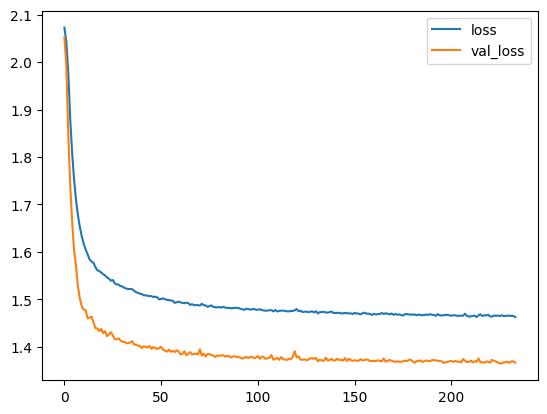

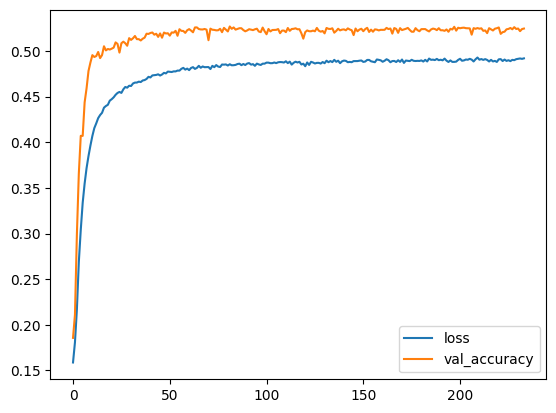

In [34]:
# loss
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")

plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label = "loss")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")

plt.legend()
plt.show()

In [24]:
import pickle
import os  # Asegúrate de importar os

# Guarda el modelo
with open('modelo_log_clf.pkl', 'wb') as file:
    pickle.dump(model, file)

# Verifica que el archivo se guardó correctamente
print(os.path.isfile('modelo_log.pkl'))

True


In [35]:
model.predict(dataset_test)

6/6 [==============================] - 0s 15ms/step


array([[6.2734098e-03, 3.1912196e-02, 4.6472631e-02, ..., 1.9552597e-01,
        1.8768299e-01, 8.3257437e-02],
       [2.0883291e-03, 3.3472154e-02, 1.5612526e-01, ..., 4.2170163e-02,
        4.5194510e-02, 3.4857854e-02],
       [4.3115348e-01, 3.7250689e-01, 3.6474612e-02, ..., 1.8168535e-02,
        4.1065846e-02, 5.3389169e-02],
       ...,
       [4.5220542e-05, 6.8627734e-04, 1.6294400e-03, ..., 9.4887853e-02,
        7.0669979e-01, 1.6289328e-01],
       [1.3113488e-03, 1.4375164e-02, 1.5995732e-02, ..., 2.6696950e-01,
        4.7026637e-01, 6.1908957e-02],
       [6.4188667e-02, 5.3171778e-01, 1.2458898e-01, ..., 2.7727304e-02,
        7.0491441e-02, 9.3126282e-02]], dtype=float32)

In [36]:
def inv_log(x):
    return np.exp(x) - 1

yhat= model.predict(dataset_test)

6/6 [==============================] - 0s 15ms/step


In [37]:
y_test = pd.Series([np.argmax(x) for x in y_test])

In [38]:
yhat = [np.argmax(x) for x in yhat]

pd.Series(yhat).value_counts()

6    12626
3    10799
4     7611
2     7362
7     6513
0     6504
1     6113
5     1524
Name: count, dtype: int64

In [39]:
pd.Series(y_test).value_counts()

0    59052
Name: count, dtype: int64

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, yhat)

0.11014021540337329

In [31]:
# df_limpio.info

In [32]:
# # Guarda el DataFrame en un archivo CSV
# df_limpio.to_csv('df_limpio.csv', index=False)

# # Verifica que el archivo se ha guardado correctamente
# print("Archivo guardado:", os.path.isfile('df_limpio.csv'))